In [1]:
import numpy as np
import pandas as pd
import Util
import pandas as pd
import requests

# download data

In [6]:
# setup stocks and time
import datetime
top = 100   # number of top weighted stocks in S&P in portfoli adjusment universe
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2023, 1, 1)

# download the symbols of stocks
df = pd.read_html(requests.get('https://www.slickcharts.com/sp500',
                      headers={'User-agent': 'Mozilla/5.0'}).text)[0]

symbols = list(df['Symbol'].values[:top])
names = list(df['Company'].values[:top])
print(f"The top {top} symbols in S&P 500 by weights order is: {symbols}")

# downloading data

import yfinance as yf
data = yf.download(symbols, start=start, end=end)
close = data['Close']

# clean the symbols that do not have data
symbols_remove = close.isna().sum()[close.isna().sum() != 0].keys()
names_remove = df[df['Symbol'].isin(symbols_remove)]['Company'].values
close = close.drop(columns=symbols_remove)
symbols = [x for x in symbols if x not in symbols_remove]
names = [x for x in names if x not in names_remove]
n_stocks = len(symbols)
print(f"In total, there are {n_stocks} stocks.")

The top 100 symbols in S&P 500 by weights order is: ['MSFT', 'AAPL', 'AMZN', 'NVDA', 'GOOGL', 'META', 'GOOG', 'TSLA', 'BRK.B', 'UNH', 'LLY', 'JPM', 'XOM', 'AVGO', 'V', 'JNJ', 'PG', 'MA', 'HD', 'ADBE', 'COST', 'CVX', 'MRK', 'ABBV', 'PEP', 'KO', 'WMT', 'CRM', 'NFLX', 'ACN', 'MCD', 'BAC', 'LIN', 'AMD', 'CSCO', 'TMO', 'INTC', 'ORCL', 'ABT', 'CMCSA', 'DIS', 'PFE', 'WFC', 'INTU', 'VZ', 'PM', 'DHR', 'AMGN', 'IBM', 'QCOM', 'TXN', 'COP', 'NOW', 'UNP', 'SPGI', 'NKE', 'GE', 'HON', 'CAT', 'BA', 'AMAT', 'NEE', 'LOW', 'RTX', 'SBUX', 'T', 'BKNG', 'ELV', 'GS', 'ISRG', 'UPS', 'MDT', 'PLD', 'BLK', 'TJX', 'BMY', 'LMT', 'SYK', 'DE', 'MS', 'MMC', 'MDLZ', 'AXP', 'PGR', 'AMT', 'LRCX', 'ADP', 'GILD', 'CB', 'ADI', 'ETN', 'VRTX', 'CVS', 'C', 'REGN', 'PANW', 'CI', 'MU', 'SCHW', 'SNPS']
[*********************100%%**********************]  100 of 100 completed


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



In total, there are 99 stocks.


# Estimators

In [7]:
from estimators import (NLS_wrapper, POET_5_wrapper,glasso_wrapper, sample_cov_wrapper)
all_estimators = {
    'glasso': glasso_wrapper,
    'NLS':  NLS_wrapper,
    'POET_5': POET_5_wrapper,
    'sample_cov': sample_cov_wrapper
}

In [ ]:
past_T = 150
oos_T = 21
last_date = len(close) - oos_T
estimator_names = ['glasso', 'NLS', 'POET_5', 'sample_cov']
# estimator_names = ['sample_cov']
results = {}
returns = {}

for estimator_name in estimator_names:
    estimator = all_estimators[estimator_name]
    estimator_portfolio_return = []

    for enddate in range(past_T, last_date, oos_T):
        # Get estimated covariance.
        pastPrices = Util.save_past_returns(close, past_T, enddate)
        X = pastPrices.values
        cov = estimator(X)
        # Get optimal portfolio weights.
        w = Util.optimal_weights(cov)
        # Calculate the return of the portfolio with given weights.
        oos_prices = Util.save_oos_returns(close, oos_T, enddate).values
        current = Util.retConstShare(oos_prices, w)
        estimator_portfolio_return.append(current)

    # store results
    returns[estimator_name] = estimator_portfolio_return
    results[estimator_name] = Util.annual_analysis(estimator_portfolio_return)

# Results

In [17]:
df = pd.DataFrame(results, index =  ['expected annual return', 'standard deviation', 'Sharpe ratio'])
df

,glasso,NLS,POET_5,sample_cov
expected annual return,9.783135,13.753683,18.547398,15.379854
standard deviation,13.325592,14.939844,14.437123,21.589598
Sharpe ratio,0.734161,0.920604,1.284702,0.712373


<Axes: title={'center': '150 days period returns'}, xlabel='period', ylabel='return'>

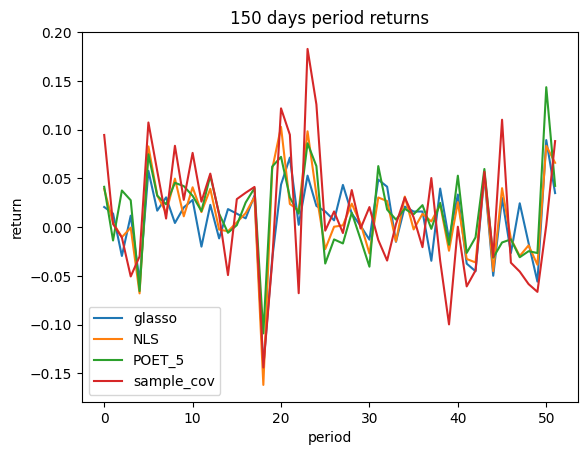

In [16]:
rets = pd.DataFrame(returns)
rets.plot(title='150 days period returns',xlabel='period',ylabel='return')